# Caso de Uso : Predicción de actividad humana en base a mediciones de un telefono móvil

La data utilizada corresponde a acelerometros y giroscopios de telefonosos Samsung Galaxy S3. Se utilizan sus acelerometros y giroscopios integrados, que capturan una aceleración lineal triaxial y la velocidad angular triaxial a una tasa de muestreo  de 50Hz. 

El objetivo es clusterizar el tipo de actividad de una eprsona en base a la información del telefono en su bolsillo (para este dataset tambien se conoce este datos, pero dado que es un ejemplo de aprendizaje no supervisado se omitirá).

URL del dataset: https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones



In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [ ]:
from google.colab import files

uploaded = files.upload()

Saving samsung_train.txt to samsung_train.txt


In [ ]:
uploaded = files.upload()

Saving samsung_train_labels.txt to samsung_train_labels.txt


In [ ]:
X = np.loadtxt("samsung_train.txt")
y = np.loadtxt("samsung_train_labels.txt")

In [ ]:
#- Un vector de 561 caracteristicas con variables en el dominio del tiempo y la freuencia 
X.shape, y.shape

((7352, 561), (7352,))

Identificar el número de clases incluido en el dataset

Obs: Esto es solo demostrativo, dado que esto es un analisis de aprendizaje no supervisado.

In [ ]:
np.unique(y)

array([1., 2., 3., 4., 5., 6.])

Estas clases corresponden a las siguientes actividades:

1. - Caminar 
2. - Subir escaleras 
3. - Bajar escaleras 
4. - Sentarse 
5. - Pararse 
6. - Acostado 


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Se reducirá las dimensiones de las caracteristicas utilizando PCA, conservando las caracteristicas necesarias para explicar el 95% de la varianza de la data.

In [ ]:
pca = PCA(n_components=0.95, random_state=101).fit(X_scaled)
X_pca = pca.transform(X_scaled)
X_pca.shape

(7352, 102)

In [ ]:
prct_var = X_pca.shape[1]/X_scaled.shape[1]
print(f'Con {X_pca.shape[1]} caracteristicas se puede explicar el fenómeno, lo que corresponde al {prct_var*100:.1f}% de las variables originales')

Con 102 caracteristicas se puede explicar el fenómeno, lo que corresponde al 18.2% de las variables originales


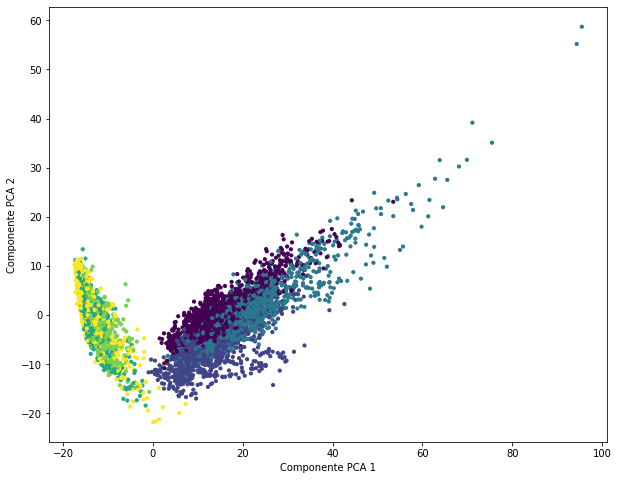

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=10);
plt.xlabel('Componente PCA 1')
plt.ylabel('Componente PCA 2')
plt.show()

Ahora se realizará la agrupación de las clases con KMeans, AgglomerativeClustering y DBSCAN utilizando el dataset pasado por PCA.

Evaluemos primero KMeans

In [ ]:
n_clases = 6
kmeans = KMeans(n_clusters=n_clases, n_init=100, 
                random_state=17)

kmeans.fit(X_pca)
cluster_labels = kmeans.labels_

Ahora visualicemos los datos para los dos principales componentes.

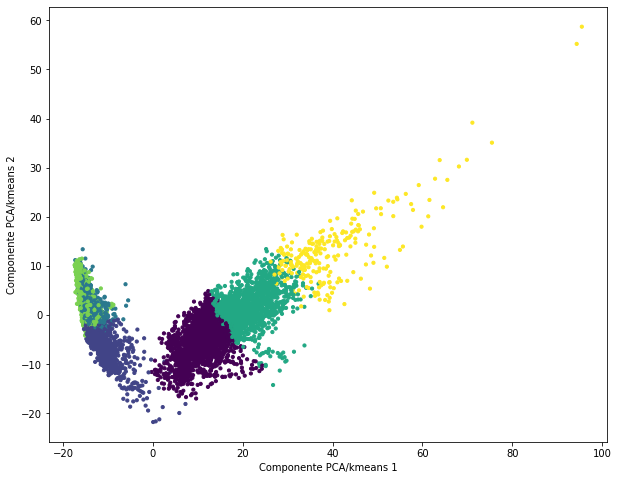

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=10)
plt.xlabel('Componente PCA/kmeans 1')
plt.ylabel('Componente PCA/kmeans 2')
plt.show()

In [ ]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['caminar', 'subir escaleras',
            'bajar escaleras', 'sentado', 'parado', 'acostado', 'todos']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['all']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,all
caminar,642,0,0,515,0,69,1226
subir escaleras,855,2,0,211,0,5,1073
bajar escaleras,200,0,0,619,0,167,986
sentado,1,315,884,0,86,0,1286
parado,0,375,999,0,0,0,1374
acostado,4,270,26,0,1107,0,1407
todos,1702,962,1909,1345,1193,241,7352


Ordenando la información, no es tan facil identificar a que actividad corresponde cada cluster. Eventualmente se podria asociar con claridad serian:
acostado .> cluster5
subir escaleras .> cluster1
bajar escaleras .> cluster4

Sin embargo, no es tan sencillo asociar cada cluster con una clase.


In [ ]:
print(f'El indice rand para KMeans es {metrics.adjusted_rand_score(y, cluster_labels):.3f}')

El indice rand para KMeans es 0.419


Ahora, evaluemos AgglomerativeClustering

In [ ]:
ag = AgglomerativeClustering(n_clusters=n_clases, 
                                     linkage='ward').fit(X_pca)

ag.labels_                                     

array([1, 1, 1, ..., 2, 2, 2])

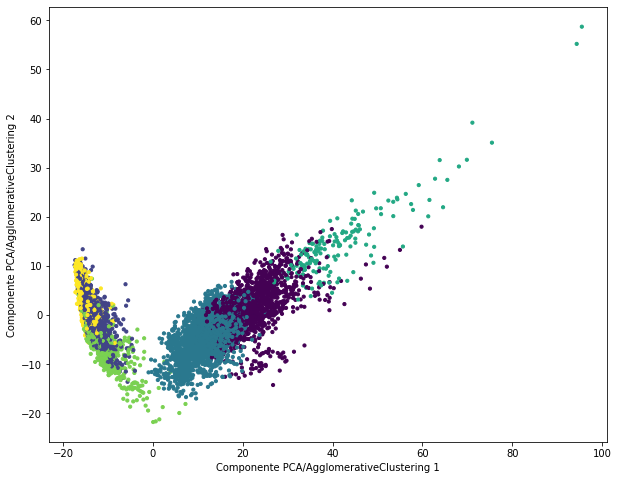

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=ag.labels_, s=10)
plt.xlabel('Componente PCA/AgglomerativeClustering 1')
plt.ylabel('Componente PCA/AgglomerativeClustering 2')
plt.show()

In [ ]:
tab = pd.crosstab(y, ag.labels_, margins=True)
tab.index = ['caminar', 'subir escaleras',
            'bajar escaleras', 'sentado', 'parado', 'acostado', 'todos']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['all']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,all
caminar,438,0,764,24,0,0,1226
subir escaleras,189,0,884,0,0,0,1073
bajar escaleras,694,0,153,139,0,0,986
sentado,0,1009,1,0,255,21,1286
parado,0,1268,0,0,105,1,1374
acostado,0,47,0,0,255,1105,1407
todos,1321,2324,1802,163,615,1127,7352


In [ ]:
print(f'El indice rand para AgglomerativeClustering es {metrics.adjusted_rand_score(y, ag.labels_):.3f}')

El indice rand para AgglomerativeClustering es 0.474


Finalmente, cluster con DBSCAN

In [ ]:
!pip install kneed

In [ ]:
#Tuning del eps

from sklearn.neighbors import NearestNeighbors

n_vecinos = 30
nearest_neighbors = NearestNeighbors(n_neighbors=n_vecinos)
neighbors = nearest_neighbors.fit(X_pca)
distances, indices = neighbors.kneighbors(X_pca)
distances = np.sort(distances[:,n_vecinos-1], axis=0)
# fig = plt.figure(figsize=(5, 5))
# plt.plot(distances)
# plt.xlabel("Puntos")
# plt.ylabel("Distancia")
# # plt.savefig("Distance_curve.png", dpi=300)
# plt.show()

18.597862903239637


<Figure size 360x360 with 0 Axes>

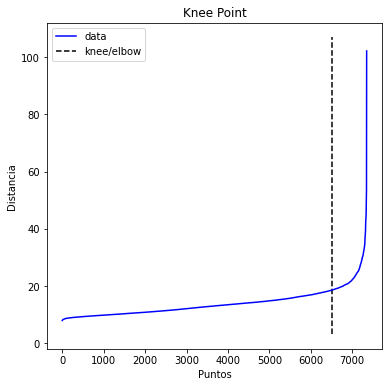

In [ ]:
from kneed import KneeLocator
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Puntos")
plt.ylabel("Distancia")

print(distances[knee.knee])
eps_opt = distances[knee.knee]

In [ ]:
db = DBSCAN(eps=eps_opt/1.5, min_samples=10).fit(X_pca)
labels = db.labels_

In [ ]:
np.unique(labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8])

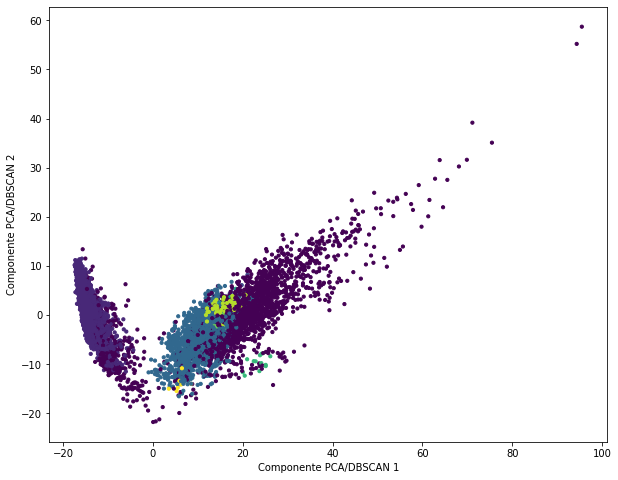

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=10)
plt.xlabel('Componente PCA/DBSCAN 1')
plt.ylabel('Componente PCA/DBSCAN 2')
plt.show()

In [ ]:
print(f'El indice rand para DBSCAN es {metrics.adjusted_rand_score(y, labels):.3f}')

El indice rand para DBSCAN es 0.288


**Conclusion**: El metodo de cluster AgglomerativeClustering tiene mejor desempeño, sin embargo, no es lo suficientemente capaz de agrupar las clases con claridad. 

En base a las tablas se podrian hacer agrupaciones más generales con mayor precisión, como por ejemplo; (1) acostado, (2) sentado+parado, (3) caminar+subir escaleras, y (4) bajar escaleras. 

In [ ]:
y_mod = []
y_mod = y

In [ ]:
y_mod = np.where(y == 6, 1, y_mod)
y_mod = np.where(y == 4, 2, y_mod)
y_mod = np.where(y == 5, 2, y_mod)
y_mod = np.where(y == 1, 3, y_mod)
y_mod = np.where(y == 2, 3, y_mod)
y_mod = np.where(y == 3, 4, y_mod)

In [ ]:
np.unique(y_mod)

array([1., 2., 3., 4.])

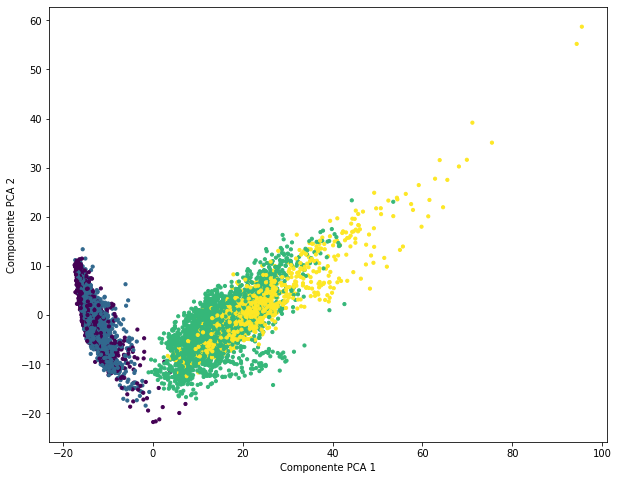

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_mod, s=10);
plt.xlabel('Componente PCA 1')
plt.ylabel('Componente PCA 2')
plt.show()

# Clausterización de Ingredientes

# Descripción del problema

Se cuenta con un data set que contiene ingredientes de hamburguesas de distintos restaurantes de todo el mundo. El data set, sin embargo, contiene mucho ruido, agregado deliberadamente para este desafío. El objetivo final, es poder construir un modelo de clasificación, sin embargo, dado que no se cuenta con las etiquetas del set de entrenamiento, esto no es solicitado en esta etapa. Para poder alimentar ese modelo de clasificación, se necesita contar con las etiquetas de los datos del data set entregado, así, se espera que ud pueda construir un modelo de clusterización que permita cumplir con dicho objetivo.

# Librerías

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE 
!pip install umap-learn
import umap
from sklearn.cluster import KMeans
!pip install kneed
from kneed import KneeLocator
from google.colab import drive

Se fija tema de Seaborn por defecto

In [ ]:
sns.set_theme(style = "darkgrid", palette = "deep")

In [ ]:
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Lectura de Datos

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Walmart/dataset.csv", sep = ";")
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,56,58,40,45,31,60,55,52,46,61,45,66,46,49,53,38,47,41,54,50,50,47,55,40,47,43
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48,48,36,47,33,47,54,36,36,38,38,53,48,59,43,58,30,47,47,41,44,46,51,43,54,34
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,54,66,41,45,27,68,52,49,54,43,43,51,43,43,58,39,41,53,56,39,52,53,54,33,52,27
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,32,20,21,25,26,37,28,27,30,25,29,26,34,20,21,32,26,28,26,29,26,27,19,25,34
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23,38,20,21,27,23,28,29,21,29,26,18,21,45,22,30,30,19,20,27,33,32,25,16,22,28


Breve estadística descriptiva

In [ ]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809
count,54966.0,54966.0,54966.0,54966.0,54966.0,54966.0,54966.0,54966.0,54966.0,54966.0,54966.0,54966.0,54966.000000,54966.000000,54966.000000,54966.000000,54966.0,54966.0,54966.0,54966.0,54966.0,54966.0,54966.0,54966.0,54966.0,54966.0,54966.0,54966.0,54966.0,54966.0,54966.0,54966.0,54966.000000,54966.000000,54966.00000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,...,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.0,54966.0,54966.0,54966.0,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002292,0.008551,0.003930,0.000164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000291,0.001001,0.00806,0.020831,0.036877,0.050522,0.109049,0.148637,...,0.597115,0.515646,0.397810,0.272568,0.154932,0.069861,0.034658,0.012917,0.012772,0.002183,0.0,0.0,0.0,0.0,30.620784,34.343358,21.889859,28.295364,21.504839,33.744860,29.497580,29.980388,31.502893,31.795528,27.527071,32.590438,28.219590,32.159862,33.262253,29.837481,27.298803,30.936870,30.836717,26.755231,28.748444,29.578394,31.571662,24.139996,30.043008,25.118783
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.496613,1.422154,0.921312,0.038388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.068245,0.203353,0.98923,2.019622,2.668140,2.842769,4.638388,5.321881,...,10.619476,9.835453,8.520468,7.203164,5.252688,3.551838,2.457606,1.349064,1.653397,0.362123,0.0,0.0,0.0,0.0,15.825020,17.363992,11.851414,14.965956,12.291558,16.838779,15.058047,15.054751,15.130281,16.500524,13.661762,16.272623,14.766899,17.424904,16.296978,16.859308,13.859270,16.459485,17.669200,14.736016,14.268756,14.872676,16.957123,13.527243,15.656138,13.391777
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,21.000000,25.000000,15.000000,19.000000,14.000000,24.000000,21.000000,22.000000,23.000000,22.000000,20.000000,23.000000,20.000000,22.000000,24.000000,19.000000,19.000000,21.000000,19.000000,17.000000,21.000000,21.000000,21.000000,15.000000,21.000000,16.000000
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,31.000000,36.000000,22.000000,28.000000,21.000000,35.000000,30.000000,31.000000,32.000000,32.000000,28.000000,33.000000,29.000000,32.000000,34.000000,29.00

Máscara para filtrar columnas con sólo ceros

In [ ]:
mask = df.columns[df.apply(np.sum, axis=0) != 0]

In [ ]:
df1 = df[mask]
df1.head()

,12,13,14,15,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,...,766,767,768,769,770,771,772,773,774,775,776,777,778,779,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,56,58,40,45,31,60,55,52,46,61,45,66,46,49,53,38,47,41,54,50,50,47,55,40,47,43
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48,48,36,47,33,47,54,36,36,38,38,53,48,59,43,58,30,47,47,41,44,46,51,43,54,34
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,54,66,41,45,27,68,52,49,54,43,43,51,43,43,58,39,41,53,56,39,52,53,54,33,52,27
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,32,20,21,25,26,37,28,27,30,25,29,26,34,20,21,32,26,28,26,29,26,27,19,25,34
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23,38,20,21,27,23,28,29,21,29,26,18,21,45,22,30,30,19,20,27,33,32,25,16,22,28


In [ ]:
df1.columns.unique()

Index(['12', '13', '14', '15', '32', '33', '34', '35', '36', '37',
       ...
       '800', '801', '802', '803', '804', '805', '806', '807', '808', '809'],
      dtype='object', length=740)

In [ ]:
df1.apply(lambda x: x.isnull().sum(), axis = 0)

12     0
13     0
14     0
15     0
32     0
      ..
805    0
806    0
807    0
808    0
809    0
Length: 740, dtype: int64

In [ ]:
df1.apply(lambda x: x.isnull().sum(), axis = 0).sum()

0

In [ ]:
df1.describe(include = "all")

,12,13,14,15,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,...,766,767,768,769,770,771,772,773,774,775,776,777,778,779,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809
count,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.00000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.00000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,...,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000
mean,0.002292,0.008551,0.003930,0.000164,0.000291,0.001001,0.00806,0.020831,0.036877,0.050522,0.109049,0.148637,0.167685,0.171160,0.168013,0.140487,0.161518,0.139559,0.085162,0.061111,0.04319,0.018284,0.008423,0.003857,0.001164,0.000764,0.004203,0.004858,0.039333,0.113907,0.224721,0.431685,0.756395,1.162646,1.704472,2.284303,2.806680,3.124095,3.118873,2.784285,...,0.268530,0.351308,0.432486,0.492122,0.597115,0.515646,0.397810,0.272568,0.154932,0.069861,0.034658,0.012917,0.012772,0.002183,30.620784,34.343358,21.889859,28.295364,21.504839,33.744860,29.497580,29.980388,31.502893,31.795528,27.527071,32.590438,28.219590,32.159862,33.262253,29.837481,27.298803,30.936870,30.836717,26.755231,28.748444,29.578394,31.571662,24.139996,30.043008,25.118783
std,0.496613,1.422154,0.921312,0.038388,0.068245,0.203353,0.98923,2.019622,2.668140,2.842769,4.638388,5.321881,5.630173,5.565988,5.592707,5.157015,5.539160,5.163356,3.960288,3.467707,2.83891,1.814677,1.111153,0.842702,0.272981,0.135553,0.605563,0.436356,2.385037,4.596626,6.595225,8.952615,12.002013,14.781231,18.000595,20.960608,23.213257,24.340302,24.543195,23.339931,...,6.797764,8.204658,8.907298,9.356913,10.619476,9.835453,8.520468,7.203164,5.252688,3.551838,2.457606,1.349064,1.653397,0.362123,15.825020,17.363992,11.851414,14.965956,12.291558,16.838779,15.058047,15.054751,15.130281,16.500524,13.661762,16.272623,14.766899,17.424904,16.296978,16.859308,13.859270,16.459485,17.669200,14.736016,14.268756,14.872676,16.957123,13.527243,15.656138,13.391777
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

Análisis de la varianza de cada variable para filtrar por dicho criterio

In [ ]:
df1.var()

12       0.246624
13       2.022523
14       0.848816
15       0.001474
32       0.004657
          ...    
805    221.196501
806    287.544023
807    182.986296
808    245.114643
809    179.339679
Length: 740, dtype: float64

Estandarización de los datos para mantener varianza en mismas unidades

In [ ]:
scaler = MinMaxScaler()
df1_fit = scaler.fit(df1)
df_n_arr = scaler.transform(df1)
df_n_arr

array([[0.        , 0.        , 0.        , ..., 0.45977011, 0.44761905,
        0.51190476],
       [0.        , 0.        , 0.        , ..., 0.49425287, 0.51428571,
        0.4047619 ],
       [0.        , 0.        , 0.        , ..., 0.37931034, 0.4952381 ,
        0.32142857],
       ...,
       [0.        , 0.        , 0.        , ..., 0.18390805, 0.19047619,
        0.26190476],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
df_n = pd.DataFrame(df_n_arr)
df_n.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.528302,0.495726,0.526316,0.478723,0.3875,0.545455,0.523810,0.495238,0.422018,0.616162,0.511364,0.634615,0.429907,0.453704,0.552083,0.365385,0.47,0.372727,0.504673,0.515464,0.490196,0.474747,0.523810,0.459770,0.447619,0.511905
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.452830,0.410256,0.473684,0.500000,0.4125,0.427273,0.514286,0.342857,0.330275,0.383838,0.431818,0.509615,0.448598,0.546296,0.447917,0.557692,0.30,0.427273,0.439252,0.422680,0.431373,0.464646,0.485714,0.494253,0.514286,0.404762
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.509434,0.564103,0.539474,0.478723,0.3375,0.618182,0.495238,0.466667,0.495413,0.434343,0.488636,0.490385,0.401869,0.398148,0.604167,0.375000,0.41,0.481818,0.523364,0.402062,0.509804,0.535354,0.514286,0.379310,0.495238,0.321429
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.311321,0.273504,0.263158,0.223404,0.3125,0.236364,0.352381,0.266667,0.247706,0.303030,0.284091,0.278846,0.242991,0.314815,0.208333,0.201923,0.32,0.236364,0.261682,0.268041,0.284314,0.262626,0.257143,0.218391,0.238095,0.404762
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.216981,0.324786,0.263158,0.223404,0.3375,0.209091,0.266667,0.276190,0.192661,0.292929,0.295455,0.173077,0.196262,0.416667,0.229167,0.288462,0.30,0.172727,0.186916,0.278351,0.323529,0.323232,0.238095,0.183908,0.209524,0.333333


In [ ]:
df_n.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739
count,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,...,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000,54966.000000
mean,0.000020,0.000034,0.000018,0.000018,0.000018,0.000021,0.000051,0.000082,0.000145,0.000199,0.000428,0.000583,0.000658,0.000671,0.000659,0.000551,0.000636,0.000547,0.000334,0.000240,0.000177,0.000072,0.000046,0.000020,0.000018,0.000026,0.000031,0.000078,0.000168,0.000447,0.000881,0.001693,0.002966,0.004559,0.006684,0.008958,0.011007,0.012251,0.012231,0.010919,...,0.001053,0.001378,0.001696,0.001930,0.002342,0.002022,0.001560,0.001069,0.000612,0.000275,0.000137,0.000051,0.000050,0.000035,0.288875,0.293533,0.288024,0.301015,0.268810,0.306771,0.280929,0.285528,0.289017,0.321167,0.312808,0.313370,0.263734,0.297777,0.346482,0.286899,0.272988,0.281244,0.288194,0.275827,0.281847,0.298772,0.300682,0.277471,0.286124,0.299033
std,0.004281,0.005599,0.004265,0.004265,0.004265,0.004327,0.006301,0.007951,0.010463,0.011192,0.018190,0.020870,0.022079,0.021827,0.021932,0.020224,0.021808,0.020248,0.015531,0.013599,0.011635,0.007116,0.006039,0.004278,0.004265,0.004674,0.004519,0.007038,0.010192,0.018026,0.025864,0.035108,0.047067,0.057966,0.070591,0.082198,0.091032,0.095452,0.096248,0.091529,...,0.026658,0.032175,0.034931,0.036694,0.041645,0.038570,0.033414,0.028248,0.020762,0.013984,0.009714,0.005332,0.006509,0.005841,0.149293,0.148410,0.155940,0.159212,0.153644,0.153080,0.143410,0.143379,0.138810,0.166672,0.155247,0.156468,0.138008,0.161342,0.169760,0.162109,0.138593,0.149632,0.165133,0.151918,0.139890,0.150229,0.161496,0.155486,0.149106,0.159426
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

In [ ]:
df_n.var().mean()

0.06950466579374369

In [ ]:
df_n.var().std()

0.0747901470734397

Visualización de la varianza de cada variable para decidir desde dónde filtrar

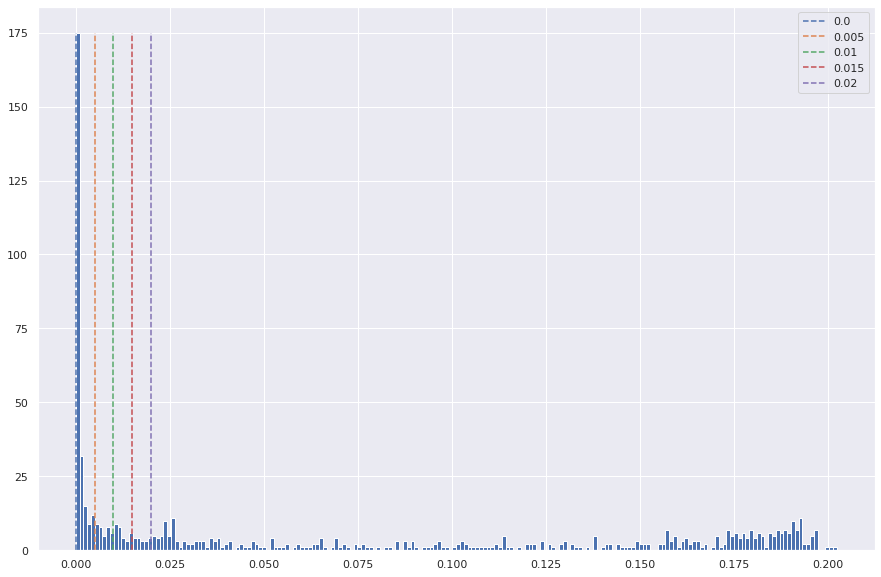

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15, 10))
plt.hist(df_n.var(), bins = 200)
xcol = np.arange(0.0, .025, 0.005)
palette = sns.color_palette(None, len(xcol))
for i, color in zip(xcol, palette):
  plt.vlines(i, ymin=0, ymax=175, colors=color, linestyles="dashed", label = i)
plt.legend();

In [ ]:
df_vars = df_n.var()
cols = df_n.columns

In [ ]:
variables = [ ]

threshold = 0.01

for i in range(0,len(df_vars)):
    if df_vars[i]>=threshold:
        variables.append(cols[i])
len(variables)

461

In [ ]:
df_filtered = df_n[variables]

In [ ]:
df_filtered.var().mean()

0.11053632283676222

In [ ]:
df_filtered.var().std()

0.06713517506920963

In [ ]:
np.sum(df_filtered.describe().loc['std'] < 0.01)

0

Filtro de variables fuertemente correlacionadas (correlación >= 0.7)

In [ ]:
cor_matrix = df_filtered.corr()

In [ ]:
greater_one = cor_matrix[(abs(cor_matrix) >= 0.7) & (abs(cor_matrix) != 1.0)]

In [ ]:
for i in range(len(greater_one)):
  for j in range(len(greater_one)):
    if j < i:
      greater_one.iloc[i, j] = 0

greater_one.fillna(0, inplace = True)

In [ ]:
corr07 = greater_one.apply(sum, axis = 0)

In [ ]:
drop_cols = corr07[corr07 != 0].index

In [ ]:
df_droped = df_filtered.drop(columns=drop_cols)

# Principal Component Analysis:
Se encuentran 4 factores principales que explican el 90% de la variabilidad. Dentro de las desventajas del PCA se encuentran la alta sensibilidad a outliers y la capacidad de sólo capturar dependencias lineales, por lo que se prefirió la implementación del método UMAP.


In [ ]:
varcov_matrix=np.array(np.cov(df_droped, rowvar=False))

In [ ]:
eigenvalues, eigenvectors = np.linalg.eig(varcov_matrix)
df_eigen = pd.DataFrame({"Eigenvalues":eigenvalues}, index=range(1, len(eigenvalues)+1))
df_eigen.head()

,Eigenvalues
1,0.068622
2,0.038815
3,0.028287
4,0.026702
5,0.020046


In [ ]:
df_eigen["explained"] = df_eigen["Eigenvalues"] / np.sum(df_eigen["Eigenvalues"])
df_eigen.sort_values(by = 'explained', ascending = False, inplace =  True)
df_eigen.style.format({"explained": "{:.1%}"})

,Eigenvalues,explained
1,0.068622,21.8%
2,0.038815,12.3%
3,0.028287,9.0%
4,0.026702,8.5%
5,0.020046,6.4%
6,0.018893,6.0%
7,0.016950,5.4%
8,0.015737,5.0%
18,0.011192,3.6%
19,0.011058,3.5%


In [ ]:
pc = df_droped.dot(eigenvectors)
pc

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.003988,-0.002087,-0.020418,0.371209,-0.287578,-0.177681,-0.044508,0.047389,-0.000228,-0.001734,-0.002760,-0.002755,0.009295,-0.031590,-0.004044,-0.140924,0.009592,-0.000599,0.015061,0.032764
1,0.003418,-0.001789,-0.017501,0.318180,-0.246495,-0.152298,-0.038150,0.040619,-0.000195,-0.001486,-0.002366,-0.002362,0.007967,-0.027078,-0.003466,-0.120792,0.008222,-0.000514,0.012909,0.028083
2,0.245470,0.260492,-0.569811,0.368798,-0.104735,-0.481712,0.211134,-0.072087,-0.004411,0.167277,-0.008631,-0.185684,0.101091,0.407850,-0.092199,-0.148718,0.353214,0.168005,-0.056692,0.158730
3,0.002350,-0.001230,-0.012032,0.218748,-0.169465,-0.104705,-0.026228,0.027925,-0.000134,-0.001022,-0.001627,-0.001624,0.005477,-0.018616,-0.002383,-0.083044,0.005652,-0.000353,0.008875,0.019307
4,-0.024363,-0.000457,-0.035353,0.151642,-0.526472,0.253190,0.581185,-0.277787,0.011808,0.012580,0.003080,0.021051,0.040085,0.022675,0.009275,0.043797,0.024179,-0.144605,0.057410,-0.128400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54961,0.269344,-0.858249,0.059104,0.183294,0.138786,-0.536961,0.359170,-0.157747,0.078205,0.026645,0.000874,-0.104539,-0.284753,-0.163085,-0.050528,-0.041675,-0.106186,-0.069259,-0.058489,0.029528
54962,0.001211,-0.000634,-0.006198,0.112689,-0.087300,-0.053939,-0.013511,0.014386,-0.000069,-0.000526,-0.000838,-0.000836,0.002822,-0.009590,-0.001228,-0.042780,0.002912,-0.000182,0.004572,0.009946
54963,0.313247,-0.036181,0.145953,0.217782,-0.231981,-0.001762,-0.105230,0.054713,0.016949,-0.100116,-0.012725,0.054197,-0.073063,0.269666,-0.021980,-0.103407,-0.004173,-0.015223,0.011399,0.010325
54964,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
explained_var = 0
variables_explain = []

for i in range(len(df_eigen)):
  while explained_var < .9:
    explained_var += df_eigen.explained.iloc[i]
    variables_explain.append(explained_var)
print(explained_var)
print(variables_explain)
print(len(variables_explain))

1.090549064542376
[0.2181098129084752, 0.4362196258169504, 0.6543294387254256, 0.8724392516339008, 1.090549064542376]
5


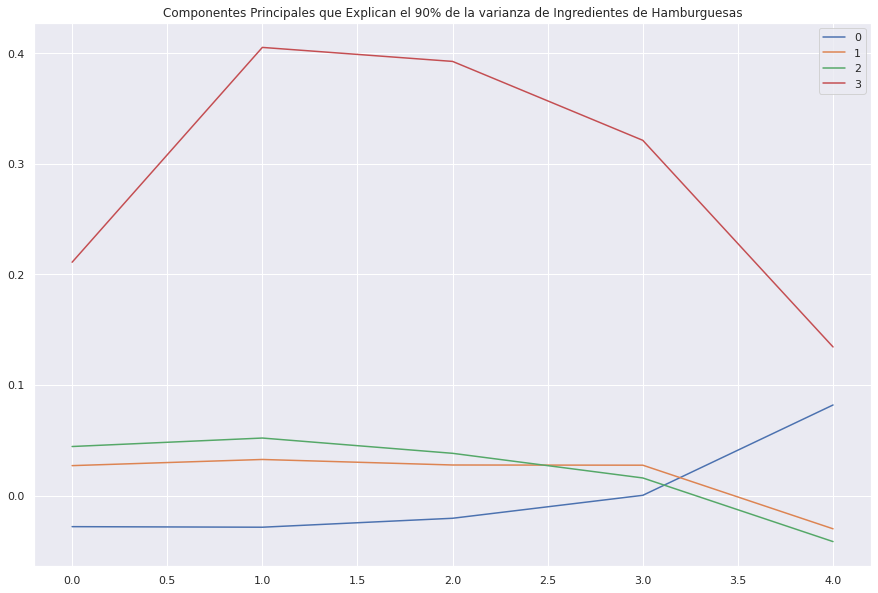

In [ ]:
pd.DataFrame(eigenvectors).iloc[:,0:4].head().plot(figsize = (15, 10), title = "Componentes Principales que Explican el 90% de la varianza de Ingredientes de Hamburguesas");

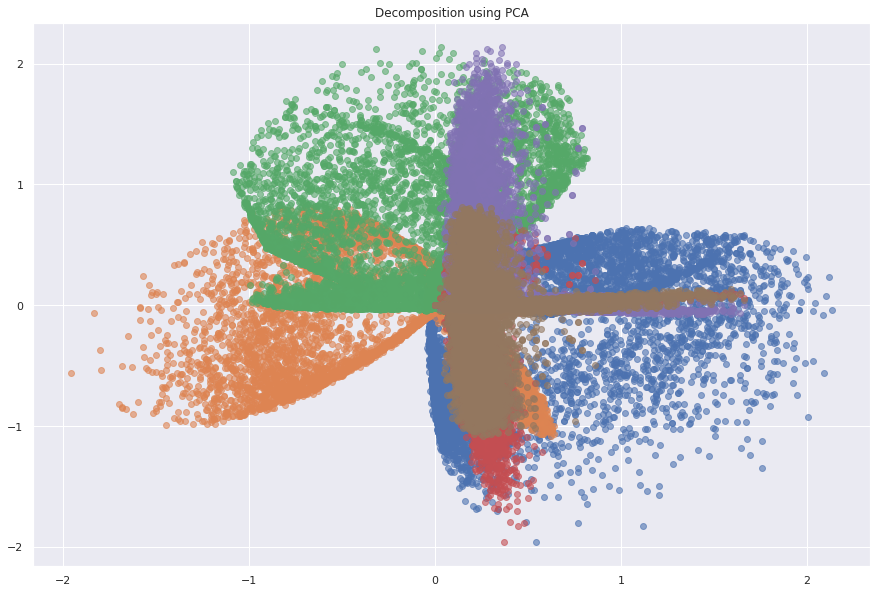

In [ ]:
pca = pc.values
plt.figure(figsize = (15, 10))
plt.title('Decomposition using PCA')
plt.scatter(pca[:,0], pca[:,1], alpha = 0.6)
plt.scatter(pca[:,1], pca[:,2], alpha = 0.6)
plt.scatter(pca[:,2], pca[:,0], alpha = 0.6)
plt.scatter(pca[:,3], pca[:,1], alpha = 0.6)
plt.scatter(pca[:,3], pca[:,0], alpha = 0.6)
plt.scatter(pca[:,3], pca[:,2], alpha = 0.6);

# UMAP (Uniform Manifold Approximation and Projection):

Si bien es menos eficiente computacionalmente que el PCA, esta metodología permite identificar dependencias no lineales sin implicar un costo computacional excesivamente alto. Adicionalmente, se observa una buena identificación de los clusters presentes en la data.


In [ ]:
umap_data = umap.UMAP(n_components=2).fit_transform(df_filtered.values)

In [ ]:
umap_data

array([[12.891418 ,  2.271265 ],
       [ 8.920467 , 15.966616 ],
       [ 6.5051975, -2.8306816],
       ...,
       [ 9.471331 , -3.691129 ],
       [-7.320282 ,  3.9658163],
       [-6.542513 ,  3.4116807]], dtype=float32)

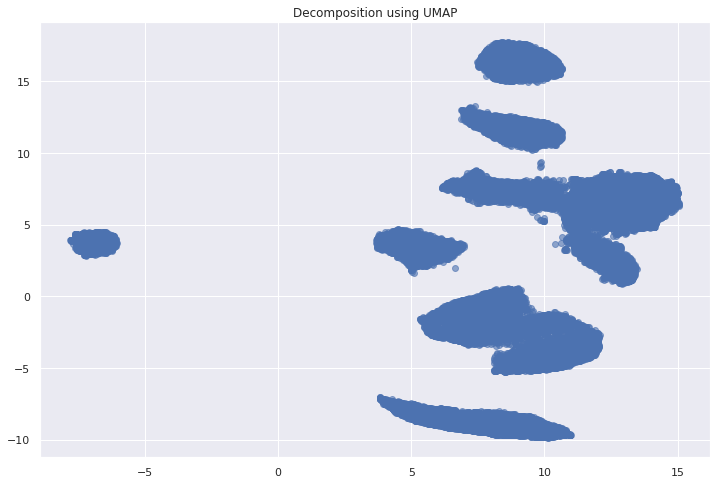

In [ ]:
plt.figure(figsize=(12,8))
plt.title('Decomposition using UMAP')
plt.scatter(umap_data[:,0], umap_data[:,1], alpha = 0.6);

# K Means

Se utiliza este algoritmo, pues es el más eficiente computacionalmente, la implementación es sencilla y provee resultados aceptables.

In [ ]:
kmeans = KMeans(init = "random",
                n_clusters = 8,
                n_init = 10,
                max_iter = 300,
                random_state = 42)

In [ ]:
kmeans.fit(umap_data)

KMeans(init='random', random_state=42)

In [ ]:
label = kmeans.fit_predict(umap_data)

In [ ]:
label

array([3, 2, 4, ..., 4, 5, 5], dtype=int32)

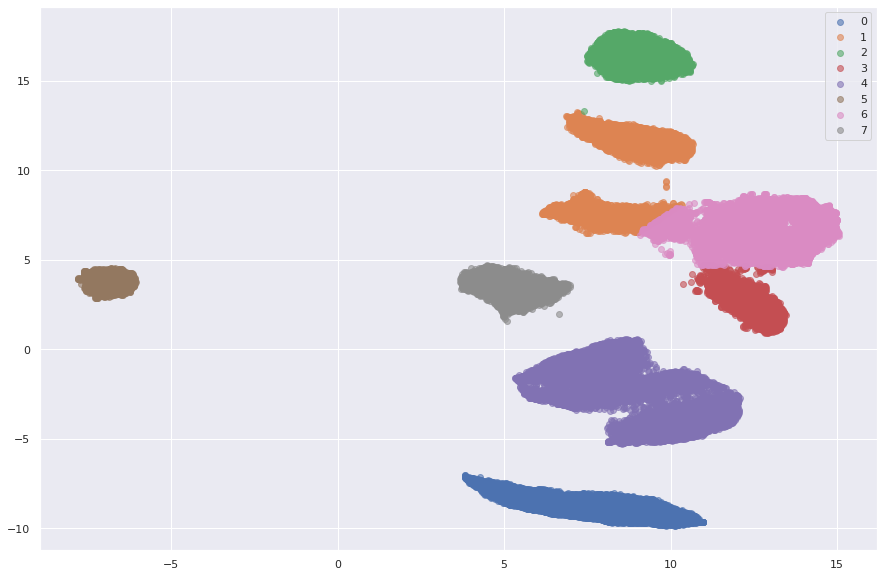

In [ ]:
u_labels = np.unique(label)

plt.figure(figsize = (15, 10))
for i in u_labels:
    plt.scatter(umap_data[label == i , 0] , umap_data[label == i , 1] , label = i, alpha=0.6)
plt.legend()
plt.show()

In [ ]:
print(f"The lowest SSE value is: {kmeans.inertia_}")
print(f"\n\nThe final locations of centroid is: {kmeans.cluster_centers_}")
print(f"\n\nThe required iterations to converge: {kmeans.n_iter_}")

The lowest SSE value is: 174896.453125


The final locations of centroid is: [[ 7.4520454 -8.674858 ]
 [ 8.521918   9.965663 ]
 [ 8.956405  16.4073   ]
 [12.317724   2.655591 ]
 [ 8.825566  -2.4567885]
 [-6.8730636  3.7278166]
 [12.517361   6.603983 ]
 [ 5.175564   3.4986343]]


The required iterations to converge: 8


In [ ]:
kmeans_kwargs = {
     "init": "random",
     "n_init": 10,
     "max_iter": 300,
     "random_state": 42,
     }

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(umap_data)
    sse.append(kmeans.inertia_)

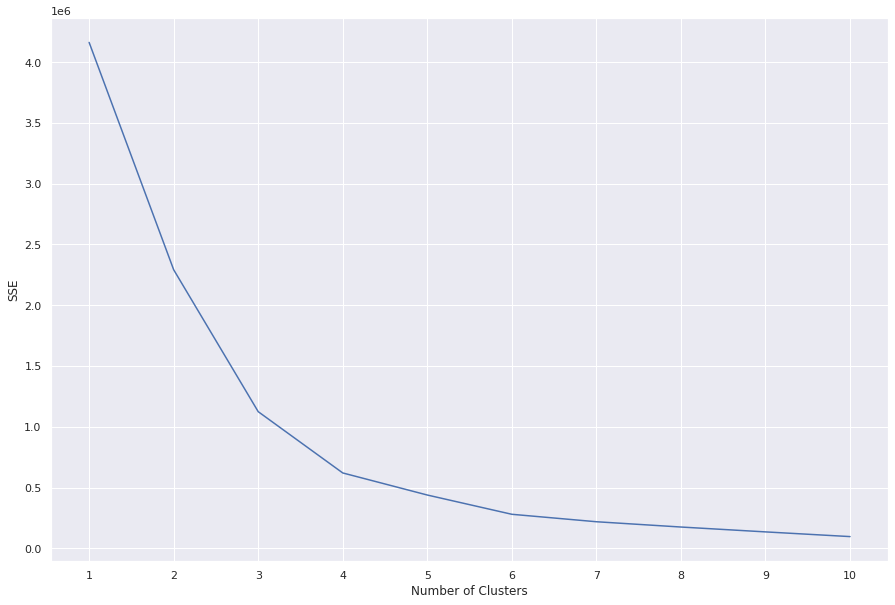

In [ ]:
plt.figure(figsize = (15, 10))
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [ ]:
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
    )

kl.elbow

4

In [ ]:
kmeans = KMeans(init = "random",
                n_clusters = kl.elbow,
                n_init = 10,
                max_iter = 300,
                random_state = 42)

In [ ]:
kmeans.fit(umap_data)

KMeans(init='random', n_clusters=4, random_state=42)

In [ ]:
label = kmeans.fit_predict(umap_data)

In [ ]:
label

array([3, 2, 0, ..., 0, 1, 1], dtype=int32)

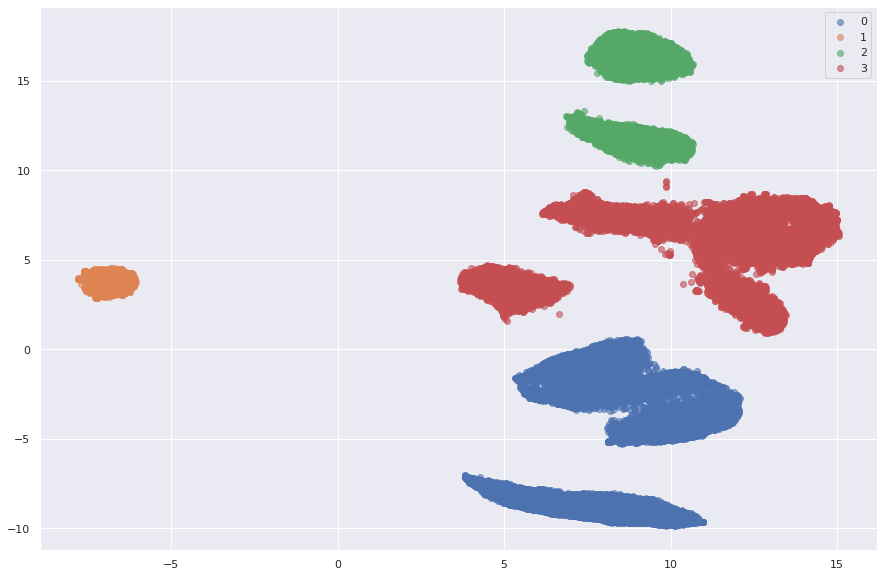

In [ ]:
u_labels = np.unique(label)

plt.figure(figsize = (15, 10))
for i in u_labels:
    plt.scatter(umap_data[label == i , 0] , umap_data[label == i , 1] , label = i, alpha=0.6)
plt.legend()
plt.show()

In [ ]:
print(f"The lowest SSE value is: {kmeans.inertia_}")
print(f"\n\nThe final locations of centroid is: {kmeans.cluster_centers_}")
print(f"\n\nThe required iterations to converge: {kmeans.n_iter_}")

The lowest SSE value is: 619748.875


The final locations of centroid is: [[ 8.444139  -4.183563 ]
 [-6.8730636  3.7278166]
 [ 8.898208  14.04759  ]
 [10.168566   5.2685976]]


The required iterations to converge: 5


In [ ]:
kmeans_pca = KMeans(init = "random",
                n_clusters = 6,
                n_init = 10,
                max_iter = 300,
                random_state = 42)

In [ ]:
kmeans_pca.fit(pca)

KMeans(init='random', n_clusters=6, random_state=42)

In [ ]:
label_pca = kmeans_pca.fit_predict(pca)

In [ ]:
label_pca

array([1, 1, 2, ..., 1, 3, 3], dtype=int32)

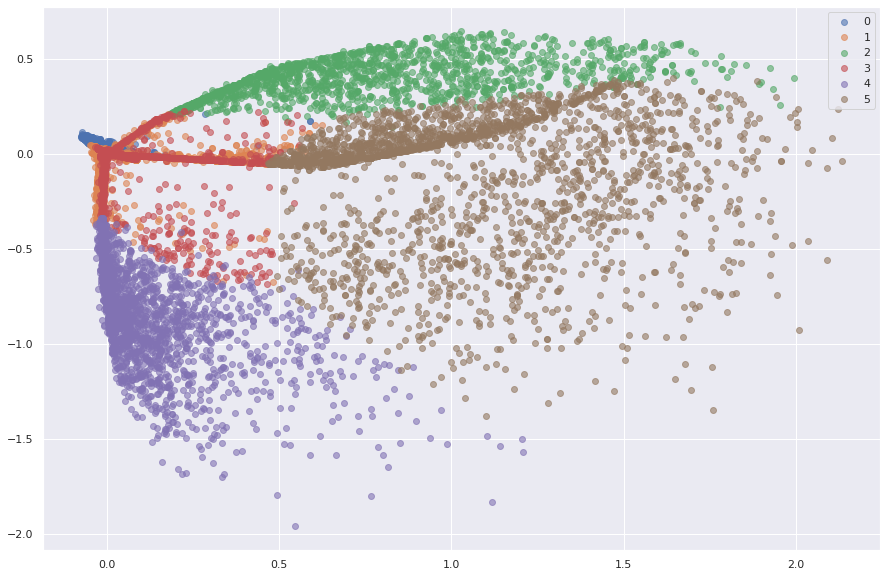

In [ ]:
u_labels_pca = np.unique(label_pca)

plt.figure(figsize = (15, 10))
for i in u_labels_pca:
    plt.scatter(pca[label_pca == i , 0] , pca[label_pca == i , 1] , label = i, alpha=0.6)
plt.legend()
plt.show()

In [ ]:
print(f"The lowest SSE value is: {kmeans.inertia_}")
print(f"\n\nThe final locations of centroid is: {kmeans.cluster_centers_}")
print(f"\n\nThe required iterations to converge: {kmeans.n_iter_}")

The lowest SSE value is: 619748.875


The final locations of centroid is: [[ 8.444139  -4.183563 ]
 [-6.8730636  3.7278166]
 [ 8.898208  14.04759  ]
 [10.168566   5.2685976]]


The required iterations to converge: 5


In [ ]:
kmeans_kwargs_pca = {
     "init": "random",
     "n_init": 10,
     "max_iter": 300,
     "random_state": 42,
     }

sse_pca = []
for k in range(1, 11):
    kmeans_pca = KMeans(n_clusters=k, **kmeans_kwargs_pca)
    kmeans_pca.fit(pca)
    sse_pca.append(kmeans_pca.inertia_)

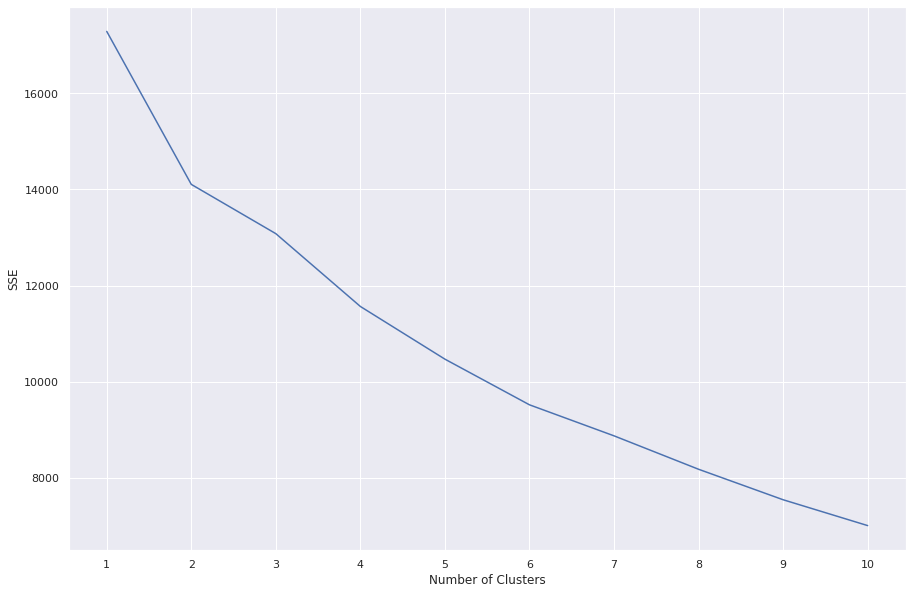

In [ ]:
plt.figure(figsize = (15, 10))
plt.plot(range(1, 11), sse_pca)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [ ]:
kl_pca = KneeLocator(
    range(1, 11), sse_pca, curve="convex", direction="decreasing"
    )

kl_pca.elbow

4

In [ ]:
kmeans_pca = KMeans(init = "random",
                n_clusters = kl_pca.elbow,
                n_init = 10,
                max_iter = 300,
                random_state = 42)

In [ ]:
kmeans_pca.fit(pca)

KMeans(init='random', n_clusters=4, random_state=42)

In [ ]:
label_pca = kmeans_pca.fit_predict(pca)

In [ ]:
label_pca

array([2, 2, 2, ..., 2, 2, 2], dtype=int32)

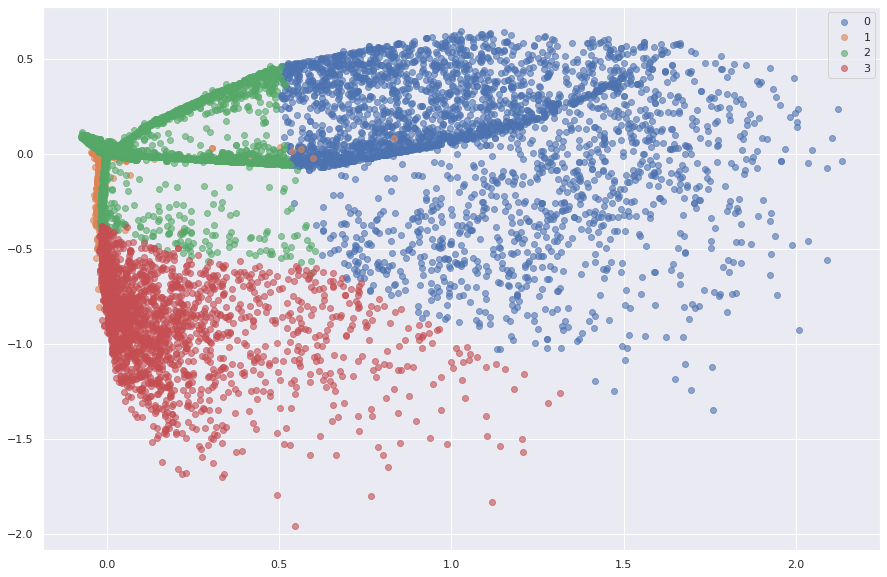

In [ ]:
u_labels_pca = np.unique(label_pca)

plt.figure(figsize = (15, 10))
for i in u_labels_pca:
    plt.scatter(pca[label_pca == i , 0] , pca[label_pca == i , 1] , label = i, alpha=0.6)
plt.legend()
plt.show()

In [ ]:
print(f"The lowest SSE value is: {kmeans_pca.inertia_}")
print(f"\n\nThe final locations of centroid is: {kmeans_pca.cluster_centers_}")
print(f"\n\nThe required iterations to converge: {kmeans_pca.n_iter_}")

The lowest SSE value is: 11563.200781620853


The final locations of centroid is: [[ 1.04410835e+00  8.79286487e-02 -5.48034693e-02  2.30613813e-01
  -1.69974264e-01 -2.90155966e-02 -4.32820307e-02  3.87417509e-03
  -4.70473537e-03  3.67900972e-03  1.26005378e-03  8.67943620e-03
  -1.11490667e-02 -7.22370720e-03 -8.84434109e-03 -4.72084568e-02
  -8.88124120e-03 -1.71055065e-02  3.13199571e-03  3.54639751e-03]
 [-1.39619139e-02 -4.24289809e-02 -8.69213041e-02  1.97361771e-01
  -5.51893228e-01  2.87598465e-01  4.95095088e-01 -2.61597355e-01
  -1.01189116e-04 -4.84300609e-05 -7.20244222e-04  1.17383245e-03
   2.47601326e-02  3.22255615e-03 -5.44886991e-03 -6.42590132e-02
  -1.36956571e-01  9.78980333e-02 -9.47396059e-02  9.15502151e-02]
 [ 9.28933492e-03  2.23389326e-03 -1.45389649e-02  2.32634244e-01
  -1.43034390e-01 -8.60746407e-02 -1.83325682e-02  1.13484608e-02
  -4.98694593e-04 -1.58529984e-03 -1.10222359e-03 -2.67038383e-03
   1.42643654e-03 -7.68364451e-03 -2.52132372e-03 -4.95696

# Caracterización de Clusters

In [ ]:
umap_data

array([[12.891418 ,  2.271265 ],
       [ 8.920467 , 15.966616 ],
       [ 6.5051975, -2.8306816],
       ...,
       [ 9.471331 , -3.691129 ],
       [-7.320282 ,  3.9658163],
       [-6.542513 ,  3.4116807]], dtype=float32)

In [ ]:
label

array([3, 2, 0, ..., 0, 1, 1], dtype=int32)

In [ ]:
data = np.concatenate((label.reshape(-1,1), umap_data), axis=1)

In [ ]:
data_df = pd.DataFrame(data)
data_df.head()

,0,1,2
0,3.0,12.891418,2.271265
1,2.0,8.920467,15.966616
2,0.0,6.505198,-2.830682
3,0.0,11.050347,-3.435088
4,0.0,11.714694,-3.143421


In [ ]:
df = pd.melt(data_df, id_vars=[0], value_vars=[1, 2])

In [ ]:
df.head()

,0,variable,value
0,3.0,1,12.891418
1,2.0,1,8.920467
2,0.0,1,6.505198
3,0.0,1,11.050347
4,0.0,1,11.714694


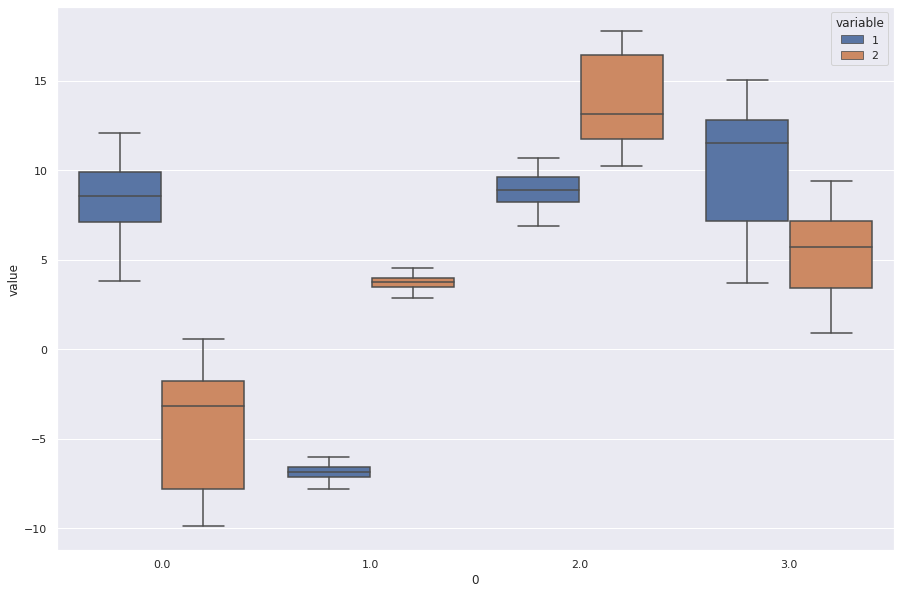

In [ ]:
plt.figure(figsize = (15, 10))
sns.boxplot(data=df, x = 0, y = "value", hue = "variable");

# Conclusión

Se puede observar cómo, luego de realizar un AED y reducir la dimensionalidad de los mismos, con el algoritmo K Means se logra identificar de buena manera los clusters presentes en los datos, seleccionando el número de clusters a través del Elbow Method y a su vez se puede apreciar cómo afectan cada factor identificado con el método UMAP a cada cluster (Boxplots). Finalmente se recomienda utilizar xgboost para la clasificación de los datos una vez que se ha provisto el dataset de etiquetas, pues es más robusto a otros algoritmos como SVM o un árbol de decisión. Este algoritmo debería ser evaluado a través de métricas de precisión, recall, ROC curve, etc

# Caso de uso
## Segregacion de clientes en base a Sexo, Ingreso y Gasto

### El siguiente es un ejemplo que obtuve de internet pero que se asemeja bastante a algo que me gustaria implementar en base a datos que aun no poseo.
### El siguiente ejemplo trata de clasificar clientes de un mall en base al sexo de estos, el ingreso anual de cada uno de ellos y a una clasificacion de gastos.
### Tengo la idea de aplicar un codigo similar a este para clasificar distintas aves que habitan dentro de un humedal en base a su comportamiento, ya sea alimentación, numero de crias, numero de integrantes en cada grupo, etc.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly as py
import plotly.graph_objs as go
from sklearn.cluster import KMeans
import warnings
import os

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving Mall_Customers.csv to Mall_Customers.csv


In [ ]:
#Leemos el archivo y vemos las columnas
df = pd.read_csv(r'Mall_Customers.csv')
df.head()


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [ ]:
df.shape

(200, 5)

In [ ]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

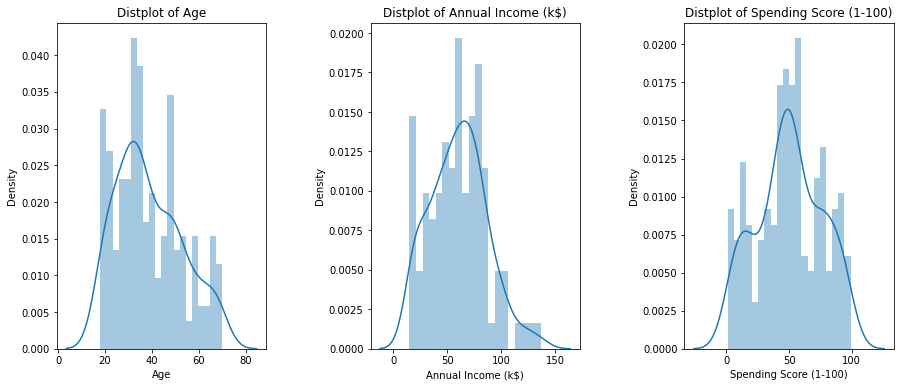

In [ ]:
#Graficamos los histogramas 
plt.figure(1 , figsize = (15 , 6))
n = 0 
for x in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
    n += 1
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
    sns.distplot(df[x] , bins = 20)
    plt.title('Distplot of {}'.format(x))
plt.show()

Se observa que todos tienen distribución normal

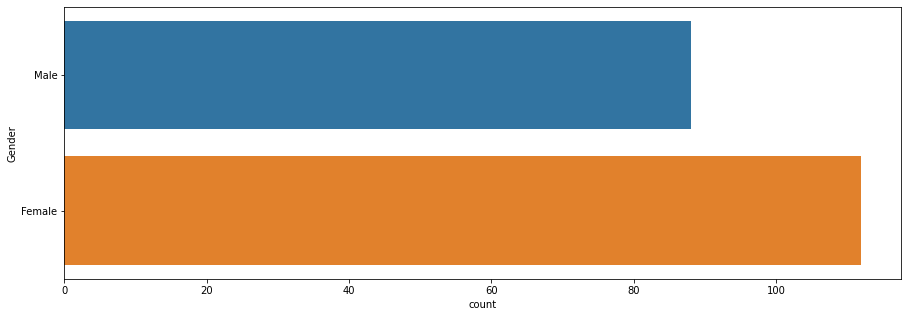

In [ ]:
#Graficamos la cantidad de hombres y mujeres en total
plt.figure(1 , figsize = (15 , 5))
sns.countplot(y = 'Gender' , data = df)
plt.show()

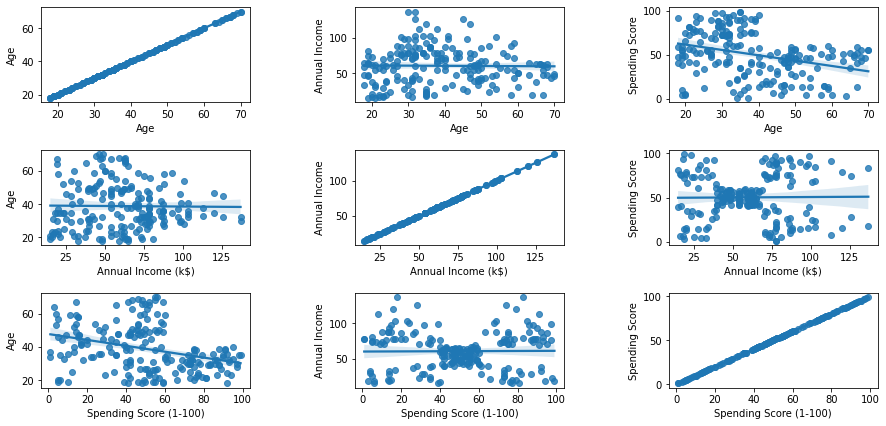

In [ ]:
#graficamos la relacion entre las distintas variables
plt.figure(1 , figsize = (15 , 7))
n = 0 
for x in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
    for y in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
        n += 1
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
        sns.regplot(x = x , y = y , data = df)
        plt.ylabel(y.split()[0]+' '+y.split()[1] if len(y.split()) > 1 else y )
plt.show()

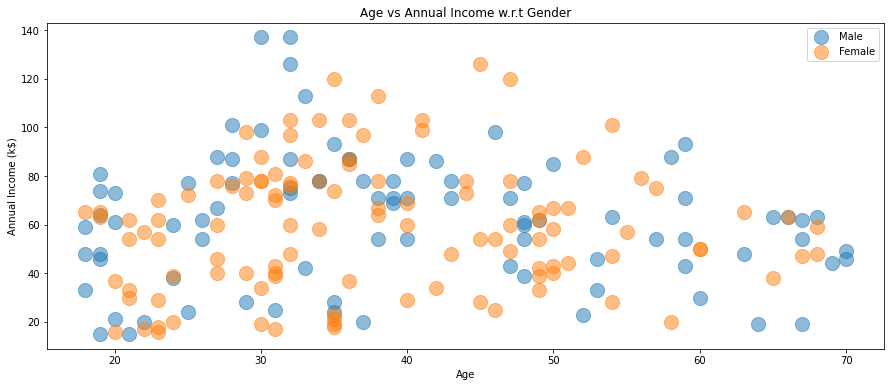

In [ ]:
plt.figure(1 , figsize = (15 , 6))
for gender in ['Male' , 'Female']:
    plt.scatter(x = 'Age' , y = 'Annual Income (k$)' , data = df[df['Gender'] == gender] ,
                s = 200 , alpha = 0.5 , label = gender)
plt.xlabel('Age'), plt.ylabel('Annual Income (k$)') 
plt.title('Age vs Annual Income w.r.t Gender')
plt.legend()
plt.show()

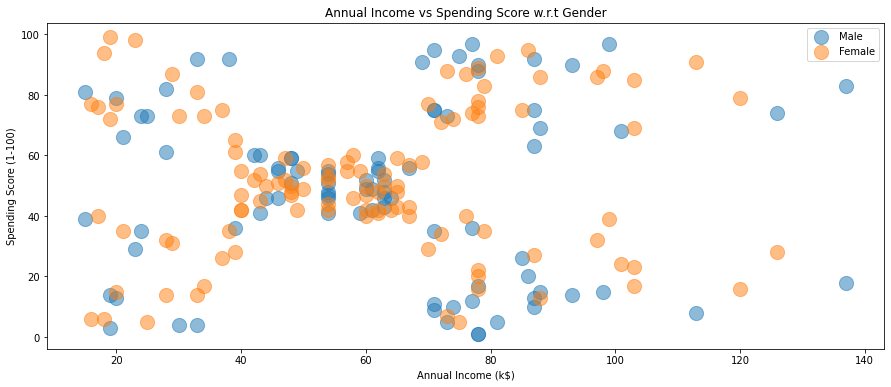

In [ ]:
plt.figure(1 , figsize = (15 , 6))
for gender in ['Male' , 'Female']:
    plt.scatter(x = 'Annual Income (k$)',y = 'Spending Score (1-100)' ,
                data = df[df['Gender'] == gender] ,s = 200 , alpha = 0.5 , label = gender)
plt.xlabel('Annual Income (k$)'), plt.ylabel('Spending Score (1-100)') 
plt.title('Annual Income vs Spending Score w.r.t Gender')
plt.legend()
plt.show()

In [ ]:
#Realizamos el algoritmo Kmeans para 11 clusters progresivos desde 1 entre la edad y la puntuacion de gasto
#Age and spending Score
X1 = df[['Age' , 'Spending Score (1-100)']].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(X1)
    inertia.append(algorithm.inertia_)

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:968: RuntimeWarning: algorithm='elkan' doesn't make sense for a single cluster. Using 'full' instead.
  RuntimeWarning,


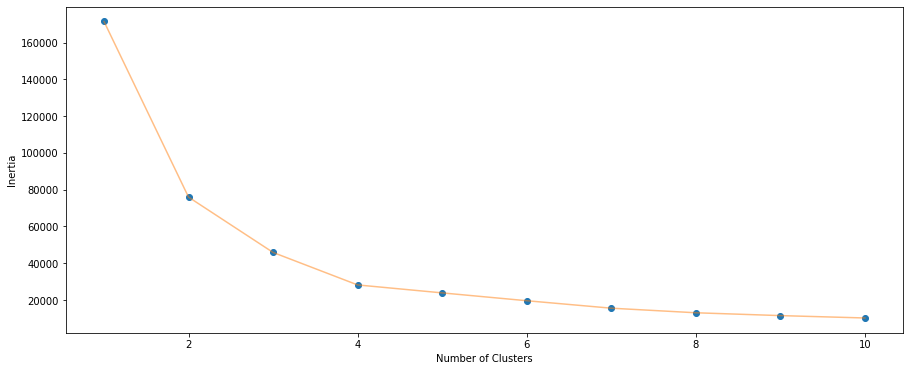

In [ ]:
#Graficamos los resultados anteriores
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

Se observa que el numero adecuado de clusters es de 4 y se procede a evaluar el modelo con 4 clusters

In [ ]:
algorithm = (KMeans(n_clusters = 4 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X1)
labels1 = algorithm.labels_
centroids1 = algorithm.cluster_centers_

In [ ]:
h = 0.02
x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()]) 

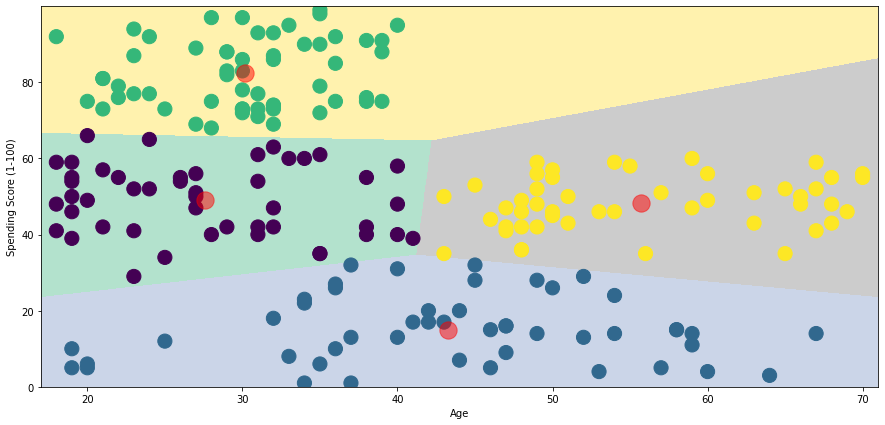

In [ ]:
#Se grafican los centroides y se le asigna colores a los distintos clusters
plt.figure(1 , figsize = (15 , 7) )
plt.clf()
Z = Z.reshape(xx.shape)
plt.imshow(Z , interpolation='nearest', 
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

plt.scatter( x = 'Age' ,y = 'Spending Score (1-100)' , data = df , c = labels1 , 
            s = 200 )
plt.scatter(x = centroids1[: , 0] , y =  centroids1[: , 1] , s = 300 , c = 'red' , alpha = 0.5)
plt.ylabel('Spending Score (1-100)') , plt.xlabel('Age')
plt.show()

Esta no es probablemente la mejor manera de diferenciar los grupos ya que no estan tan bien definidos los distintos grupos.

In [ ]:
#Probamos con una nueva combinacion de caracteristicas, esta vez con el ingreso anual y el puntaje de gasto
#Igual que la vez anterior evaluamos varios numeros de clusters para determinar cual es el mejor de acuerdo al metodo del codo
#Annual Income and spending Score
X2 = df[['Annual Income (k$)' , 'Spending Score (1-100)']].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(X2)
    inertia.append(algorithm.inertia_)

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:968: RuntimeWarning: algorithm='elkan' doesn't make sense for a single cluster. Using 'full' instead.
  RuntimeWarning,


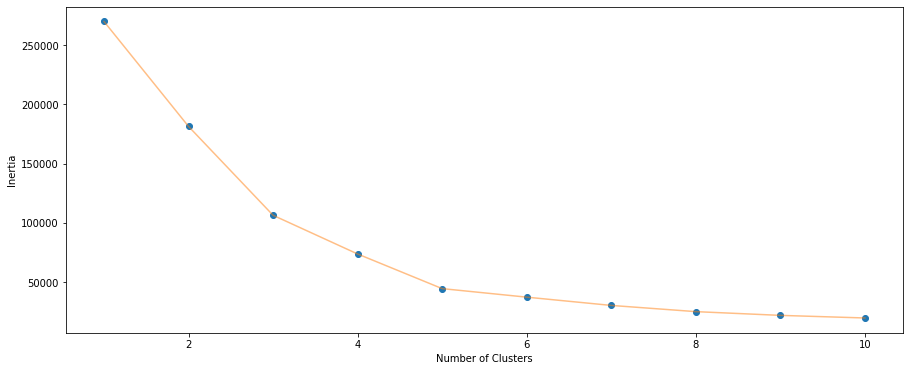

In [ ]:
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

En base a lo que indica la figura se aprecia que 5 clusters es lo optimo para esta combinacion de caracteristicas.
Se procede a evaluar el modelo en base a estas dos variables y determinando 5 grupos.

In [ ]:
algorithm = (KMeans(n_clusters = 5 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X2)
labels2 = algorithm.labels_
centroids2 = algorithm.cluster_centers_

In [ ]:
h = 0.02
x_min, x_max = X2[:, 0].min() - 1, X2[:, 0].max() + 1
y_min, y_max = X2[:, 1].min() - 1, X2[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z2 = algorithm.predict(np.c_[xx.ravel(), yy.ravel()]) 

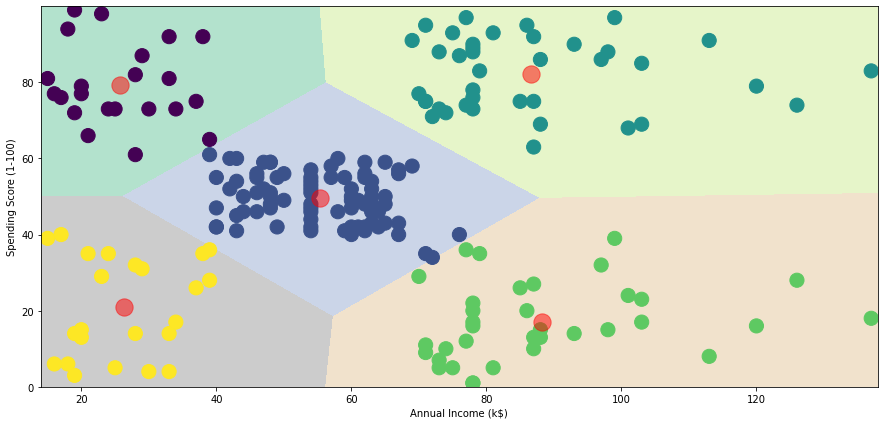

In [ ]:
plt.figure(1 , figsize = (15 , 7) )
plt.clf()
Z2 = Z2.reshape(xx.shape)
plt.imshow(Z2 , interpolation='nearest', 
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

plt.scatter( x = 'Annual Income (k$)' ,y = 'Spending Score (1-100)' , data = df , c = labels2 , 
            s = 200 )
plt.scatter(x = centroids2[: , 0] , y =  centroids2[: , 1] , s = 300 , c = 'red' , alpha = 0.5)
plt.ylabel('Spending Score (1-100)') , plt.xlabel('Annual Income (k$)')
plt.show()

Se logran identificar bastante bien los diversos grupos de compradores que hay, coo en general sucede hacia los limites de los grupos hay un poco mas de error, pero de todas maneras se identifican claramente los 5 grupos.

Mi idea es desarrollar este mismo principio, un aprendizaje no supervisado para clasificar diversas aves, ya que estas tienen comportamientos bastante diversos. Sin embargo es una idea que tengo a futuro para lo cual necesito colectar bastante data antes de poder implementarla. Creo que el algoritmo K-means funciona bastante bien para este tipo de data, es bastante rapido de implementar y con resultados muy acertados.

In [ ]:
# El objetivo de este codigo, es leer todos los numeros de una imagen,

# Se entrena el modelo utilizando un dataset de sklearn y se analiza con profundidad.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

origin = load_digits()

In [ ]:
# Se estandarizan los datos.

from sklearn.preprocessing import StandardScaler
df = StandardScaler().fit_transform(origin.data)
 
print(df.shape)

(1797, 64)


In [ ]:
# Matriz de Covarianza
cov_matrix = np.cov(df.T)
print("Shape of Covariance Matrix :  ", cov_matrix.shape)

Shape of Covariance Matrix :   (64, 64)


In [ ]:
# Se transforma la data

EValue, EVector = np.linalg.eig(cov_matrix)
Z = np.dot(df,EVector)
Z.shape

(1797, 64)

In [ ]:
# Modelo PCA

from sklearn.decomposition  import PCA
from mpl_toolkits.mplot3d import axes3d, Axes3D  

pca = PCA(n_components=3) # n_components, para definir la reduccion de componentes, ya que cada dato tenia 64 componentes.
pca.fit(df.data)
Z1 = pca.transform(df.data)
print("Shape de la data transformada : ", Z1.shape)

Shape de la data transformada :  (1797, 3)


In [ ]:
# Combinar las dimensiones
new_dataframe = pd.DataFrame(Z1)
new_dataframe.columns=['dim_1','dim_2','dim_3']
new_dataframe['labels'] = origin.target
new_dataframe.head()

,dim_1,dim_2,dim_3,labels
0,1.914215,-0.954502,-3.946032,0
1,0.588980,0.924637,3.924754,1
2,1.302037,-0.317187,3.023319,2
3,-3.020771,-0.868773,-0.801747,3
4,4.528949,-1.093480,0.973119,4


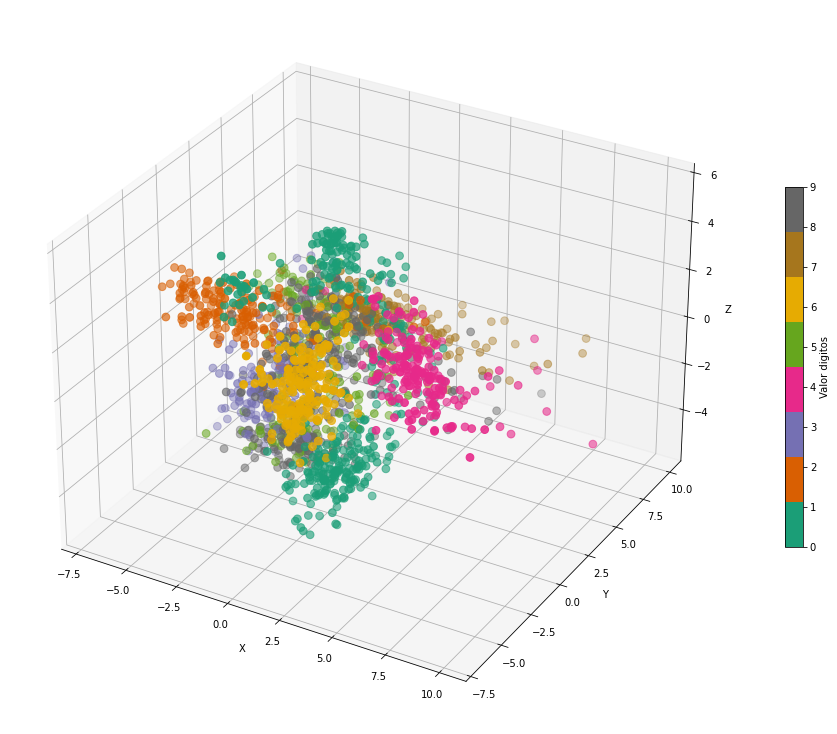

In [ ]:
# Visualizacion en 3 dimensiones

fig = plt.figure(figsize=(16,10))
ax = Axes3D(fig)
p = ax.scatter(xs=new_dataframe['dim_1'], ys=new_dataframe['dim_2'], zs=new_dataframe['dim_3'], c=new_dataframe['labels'], cmap='Dark2',marker='o',s=60)#i)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.colorbar(p,orientation='vertical',shrink = 0.5,label='Valor digitos')
plt.show()

In [ ]:
import imageio

# Lectura de imagen
img = imageio.imread('ImagenCaso.jpg')

Se planea dividir la imagen utilizando las lineas negras como referencia con "np.asarray",

En un caso real, hay que bajar la calidad de la imagen hasta tener los numeros separados por un espectro de color similar (Usualmente seria blanco o derivados de blanco), asi separar los numeros en imagenes diferentes y luego estandarizar el tamaño de cada uno.

Como no encontre la forma, sera dividido en **multiplos de 40.**

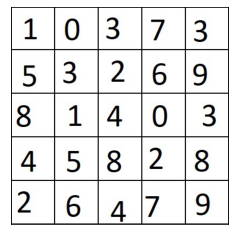

In [ ]:
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(img);

In [ ]:
img_y, img_x, pixel = img.shape # x = ancho \\ y = alto
alto = 80
ancho = 80

array = np.zeros((img_y // alto,
                  img_x // ancho,
                  alto,
                  ancho,
                  pixel))

y = x = 0

for i in range(0, img_y, alto):
    for j in range(0, img_x, ancho):
        array[y][x] = img[i:i+alto,
                          j:j+ancho,
                         :pixel]
        x +=1
    y += 1
    x = 0

In [ ]:
array.shape

(5, 5, 80, 80, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


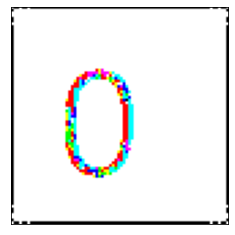

In [ ]:
# Tiene las imagenes cortadas, pero por alguna razon, las devuelve con un color completamente diferente.

ax = plt.axes(xticks=[], yticks=[])
ax.imshow(array[0,1]);

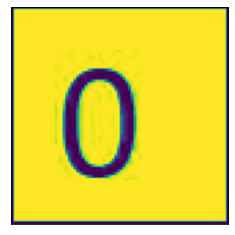

In [ ]:
# Esto pasa si solo usamos un componente, tiene mas sentido.

ax = plt.axes(xticks=[], yticks=[])
ax.imshow(array[0,1,:,:,0]);

In [ ]:
# Ahora falta preparar cada imagen en arrays que cumplan la lectura del modelo.

# Caso de uso: Estado de cobertura servicios.
 

Luego de la asignación de turnos de los ejecutivos de atención a cliente, se obtiene una imagen donde se distinguen la cantidad de ejecutivos asignados según los intervalos horarios (de 30 minutos) por día y cada intervalo está marcado con diferentes colores de acurdo a si se cubre o no el requerido semanal según la proyección realizada (los colores están definidos para todos los servicios del país). 

La idea es tomar esa imagen y a través de los colores dominantes obtener una imagen que indique si el servicio se encuentra con cobertura completa, con over staff o bien under staff.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Lectura de imagen y sus dimensiones

import matplotlib.image as img

image = img.imread("/content/drive/MyDrive/Diplomado data science/VI. Aprendizaje no supervisado/imagen_ejemplo.jpg")
print("Las dimensiones de la imagen son ",image.shape)

Las dimensiones de la imagen son  (168, 300, 3)


La imagen a evaluar es


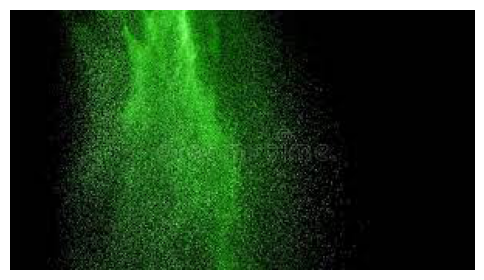

In [ ]:
# Se obtiene una visualización de la imagen
print("La imagen a evaluar es")
plt.figure(dpi=100)
plt.axis('off')
plt.imshow(image)
plt.show()

In [ ]:
r,g,b=[],[],[]

for row in image:
    for temp_r, temp_g, temp_b in row:
        r.append(temp_r)
        g.append(temp_g)
        b.append(temp_b)

print(sum(b))
print(sum(g))
print(sum(r))

728676
2333460
868523


In [ ]:
from scipy.cluster.vq import whiten 

scaled_red = whiten(r)
scaled_blue = whiten(b)
scaled_green = whiten(g) 

print(sum(scaled_red))
print(sum(scaled_blue))
print(sum(scaled_green))

38612.11468618609
37112.35117786039
41335.664115310414


In [ ]:
import pandas as pd
df = pd.DataFrame({'red':r,
                   'blue':b,
                   'green':g,
                   'scaled_red':scaled_red,
                   'scaled_blue':scaled_blue,
                   'scaled_green':scaled_green})
df.head()

,red,blue,green,scaled_red,scaled_blue,scaled_green
0,1,1,1,0.044457,0.050931,0.017714
1,1,1,1,0.044457,0.050931,0.017714
2,1,1,1,0.044457,0.050931,0.017714
3,1,1,1,0.044457,0.050931,0.017714
4,1,1,1,0.044457,0.050931,0.017714


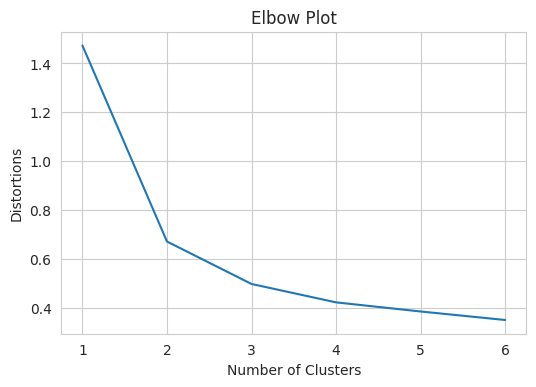

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.cluster.vq import kmeans,vq

distortions = []
num_clusters = range(1, 7)

for i in num_clusters:
    cluster_centers, distortion = kmeans(df[['scaled_red','scaled_blue','scaled_green']],i)
    distortions.append(distortion)

elbow_plot = pd.DataFrame({'num_clusters':num_clusters,'distortions':distortions})

plt.figure(dpi=100)
sns.lineplot(x='num_clusters', y='distortions', data = elbow_plot)
plt.xticks(num_clusters)
plt.title('Elbow Plot')
plt.xlabel('Number of Clusters')
plt.ylabel("Distortions")
plt.show()

In [ ]:

cluster_centers, distortion = kmeans(df[['scaled_red','scaled_blue','scaled_green']],3)
print(cluster_centers)

[[2.48657711 2.42753412 2.34338715]
 [0.98512744 0.89680849 1.28113552]
 [0.07774756 0.08267467 0.09883407]]


In [ ]:
r_std, g_std, b_std = df[['red', 'green', 'blue']].std()

colors = []

for cluster_center in cluster_centers:
    scaled_r, scaled_g, scaled_b = cluster_center
    colors.append((
        scaled_r * r_std / 255,
        scaled_g * g_std / 255,
        scaled_b * b_std / 255
    ))

print(colors)

[(0.21944229537461657, 0.5290813816096851, 0.18043273379708996), (0.08693823523247503, 0.19545952794609855, 0.09864301922287765), (0.006861280882729241, 0.01801895628532028, 0.0076098826971231215)]


Los colores dominantes de la imagen son


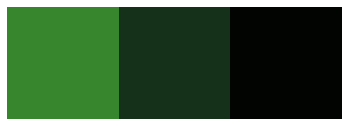

In [ ]:
print("Los colores dominantes de la imagen son")
plt.axis('off')
plt.imshow([colors])
plt.show()


Con esto, se obtiene una representación gráfica respecto al estado de los servicios que existen en la empresa. Así, se puede observar de manera rápida si los servicios cuentan con over o under staff, logrando poder distribuir los recursos de acuerdo a la disponibilidad que existe.
